<a href="https://colab.research.google.com/github/businsweetie/deep_learning/blob/main/Task_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек и функции

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras import layers

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
def plot_training_curves(history):
  loss_values = history.history['loss'] # ошибка на тренировочном наборе
  val_loss_values = history.history['val_loss'] # ошибка на валидационном наборе
  acc_values = history.history['accuracy']  # точность на тренировочном наборе
  val_acc_values = history.history['val_accuracy'] # точность на валидационном наборе

  epochs_x = range(1, len(loss_values) + 1) # количество эпох обучения

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # график значения функции потерь на каждой эпохе
  ax1.plot(epochs_x, loss_values, 'b-o', label='Ошибка обучения')
  ax1.plot(epochs_x, val_loss_values, 'r-o', label='Ошибка валидации')
  ax1.set_title('Ошибка при обучении и валидации', fontsize=14, fontweight="bold")
  ax1.set_xlabel('Эпохи', fontsize=12)
  ax1.set_ylabel('Значение ошибки', fontsize=12)
  ax1.grid()
  ax1.legend()

  # график значения точности на каждой эпохе
  ax2.plot(epochs_x, acc_values, 'b-o', label='Точность обучения')
  ax2.plot(epochs_x, val_acc_values, 'r-o', label='Точность валидации')
  ax2.set_title('Точность при обучении и валидации', fontsize=14, fontweight="bold")
  ax2.set_xlabel('Эпохи', fontsize=12)
  ax2.set_ylabel('Значение точности', fontsize=12)
  ax2.grid()
  ax2.legend()

  return

def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
  # подсчет матрицы ощибок
  cm = confusion_matrix(y_true, y_pred)

  # размер изображения
  plt.figure(figsize=figsize)

  # визуалиазиция матрицы ощибок
  disp = sns.heatmap(
      cm, annot=True, cmap='Greens', cbar=False,
      annot_kws={"size": text_size}, fmt='g',
      linewidths=.5, linecolor='black', clip_on=False,
      xticklabels=classes, yticklabels=classes)

  disp.set_title('Матрица ощибок', fontsize=14, fontweight="bold")
  disp.set_xlabel('Предсказанные значения', fontsize=12)
  disp.set_ylabel('Истинные значения', fontsize=12)
  plt.yticks(rotation=0)

  plt.show()

  return

# Функция для подсчета метрик модели классификации
def generate_preformance_scores(y_true, y_pred, y_probabilities):

  model_accuracy = balanced_accuracy_score(y_true, y_pred)
  model_precision = precision_score(y_true, y_pred)
  model_recall = recall_score(y_true, y_pred)
  model_roc_auc = roc_auc_score(y_true, y_probabilities)


  print(f'Accuracy Score:\t\t{model_accuracy:.4f}')
  print(f'Precision_score:\t{model_precision:.4f}')
  print(f'Recall_score:\t\t{model_recall:.4f}')
  print(f'AUC Score:\t\t{model_roc_auc:.4f}')

  preformance_scores = {
      'accuracy_score': model_accuracy,
      'precision_score': model_precision,
      'recall_score': model_recall,
      'auc_score': model_roc_auc,
  }

  return preformance_scores


def plot_roc_curve(y_test, y_prob):
    auc = roc_auc_score(y_test, y_prob)
    fper, tper, thresholds = roc_curve(y_test, y_prob)
    plt.plot(fper, tper, color="green", label=f"AUC = {round(auc, 3)}")
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("График ROC-кривой", fontsize=14, fontweight="bold")
    plt.grid()
    plt.legend(loc=4)
    plt.show()

# Загрузка набора данных

In [4]:
# получение токена для загрузки набора данных с сайта kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dashkabugashka","key":"120cb24fa13253988e528a5054fa0b13"}'}

In [5]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Oct 19 04:25 kaggle.json


In [6]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [7]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d alexteboul/diabetes-health-indicators-dataset

 83% 5.00M/6.03M [00:00<00:00, 48.6MB/s]
100% 6.03M/6.03M [00:00<00:00, 56.2MB/s]


# Чтение данных

In [9]:
# разархивирование данных
!unzip "/content/diabetes-health-indicators-dataset.zip" -d "/content/diabetes"

Archive:  /content/diabetes-health-indicators-dataset.zip
  inflating: /content/diabetes/diabetes_012_health_indicators_BRFSS2015.csv  
  inflating: /content/diabetes/diabetes_binary_5050split_health_indicators_BRFSS2015.csv  
  inflating: /content/diabetes/diabetes_binary_health_indicators_BRFSS2015.csv  


In [91]:
df = pd.read_csv('/content/diabetes/diabetes_binary_health_indicators_BRFSS2015.csv') # читаем данные в перменную df
df.head() # выводим первые 5 строк

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


# Исследование данных

In [11]:
df.describe() # информация о числовых характеристиках переменных

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [12]:
df.info() # информация о пропущенных знначениях и типах переменной

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [13]:
unique_values = {}
for col in df.columns:
    unique_values[col] = df[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['Количество уникальных значений']).transpose()

,Количество уникальных значений
Diabetes_binary,2
HighBP,2
HighChol,2
CholCheck,2
BMI,84
Smoker,2
Stroke,2
HeartDiseaseorAttack,2
PhysActivity,2
Fruits,2


In [96]:
df.duplicated().sum()

24206

In [97]:
df = df.drop_duplicates()
df.duplicated().sum()

0

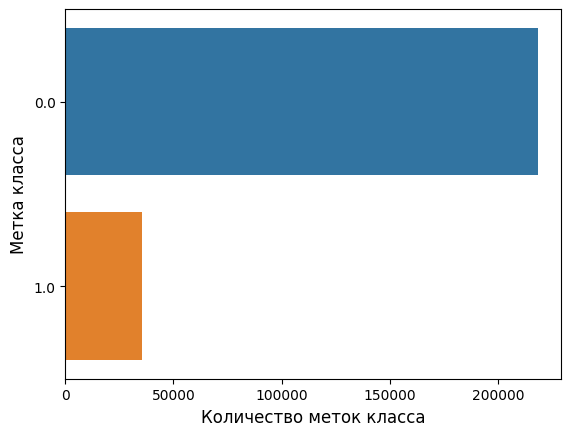

In [94]:
# визуализация количества меток класса
sns.countplot(y=df['Diabetes_binary'] ,data=df)
plt.xlabel("Количество меток класса", fontsize=12)
plt.ylabel("Метка класса", fontsize=12)
plt.show()

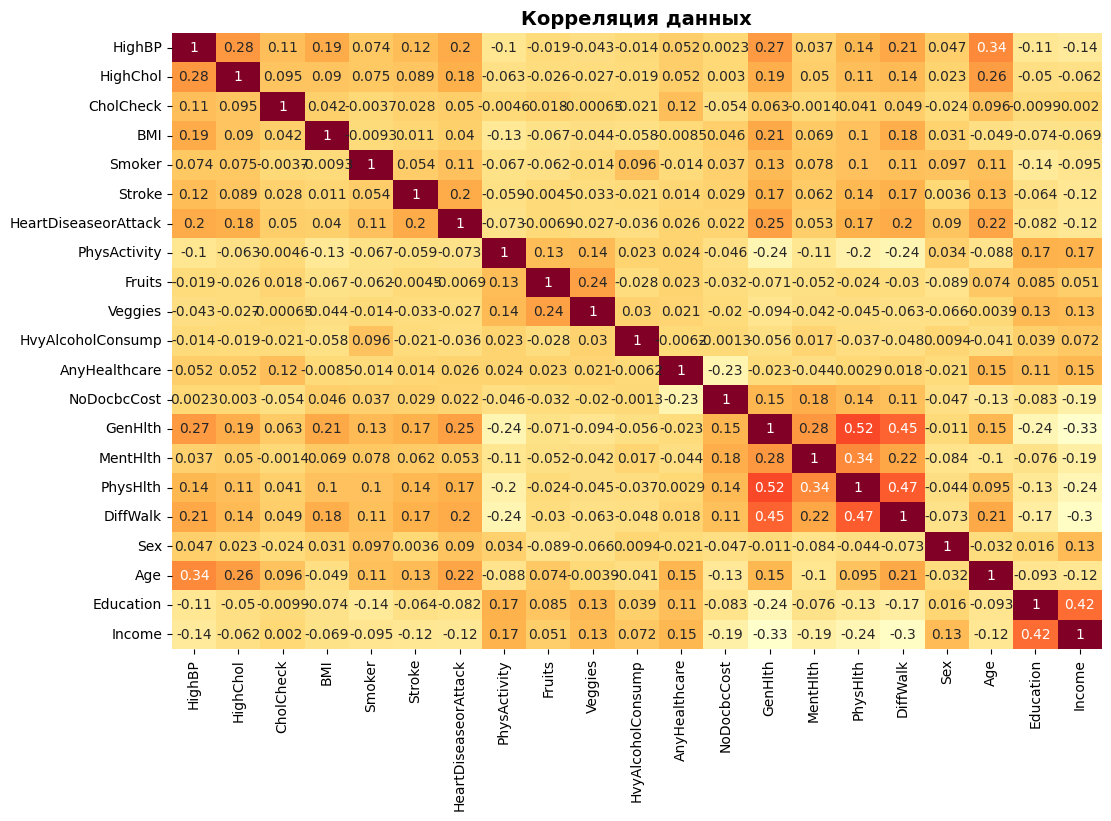

In [17]:
plt.figure(figsize = (12, 8))
sns.heatmap(df.drop("Diabetes_binary", axis=1).corr(), annot=True, cmap ='YlOrRd', cbar=False)
plt.title("Корреляция данных", fontsize=14, fontweight="bold");

Correlation heatmap show relation between columns:

(GenHlth ,PhysHlth ),(PhysHlth , DiffWalk),(GenHlth ,DiffWalk )are highly correleted with each other => positive relation

(GenHlth ,Income ) , (DiffWalk , Income) are highly correleted with each other => Nagative relation

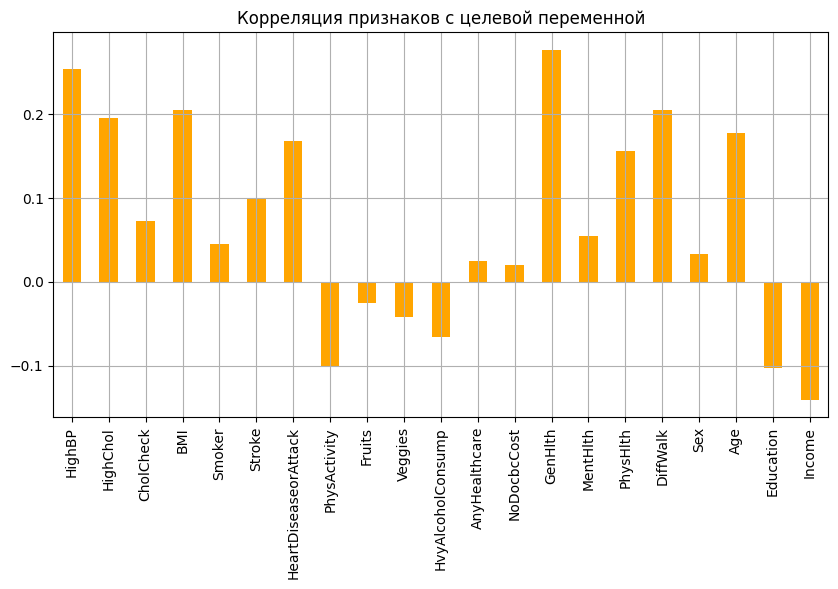

In [18]:
df.drop('Diabetes_binary', axis=1).corrwith(df.Diabetes_binary).plot(kind='bar',
                                                                     grid=True,
                                                                     figsize=(10, 5),
                                                                     title="Корреляция признаков с целевой переменной",
                                                                     color="orange");

Diabetes_binary's relation with other columns Through bar Graph Result:

Fruits , AnyHealthcare , NoDocbccost and sex are least correlated with Diabetes_binary.

HighBP , HighChol , BMI , smoker , stroke , HeartDiseaseorAttack , PhysActivity , Veggies , MentHlth , HvyAlcoholconsump , GenHlth , PhysHlth , Age , Education , Income and DiffWalk have a significant correlation with Diabetes_binary.

# Деление на выборки

In [20]:
# делим выборку на тренировочную и тестовую
X = df.drop(['Diabetes_binary'],axis=1).values # удаляем целевую переменную из общего набора данных
y = df['Diabetes_binary'].values # создаем отделтнуб переменную для целевого признака
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и тестовый в соотношениии 80/20 (train/test)
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и валидационный в соотношениии 80/20 (train/test)

In [21]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер тренировочной выборки: (146863, 21)
Размер тестовой выборки: (45895, 21)
Размер валидационной выборки: (36716, 21)


In [22]:
# проводим стандартизацию данных, для лучшей работы нейронной сети
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Создание модели

In [37]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

callbacks_list=[early_stop]

## Модель 1

In [38]:
model1 = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [39]:
# компиляция модели
model1.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 12)                264       
                                                                 
 dense_17 (Dense)            (None, 8)                 104       
                                                                 
 dense_18 (Dense)            (None, 4)                 36        
                                                                 
 dense_19 (Dense)            (None, 1)                 5         
                                                                 
Total params: 409 (1.60 KB)
Trainable params: 409 (1.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [40]:
history1 = model1.fit(X_train,
                      y_train,
                      epochs=50,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/50
4590/4590 [==============================] - 12s 2ms/step - loss: 0.4340 - accuracy: 0.8483 - val_loss: 5.6532 - val_accuracy: 0.1533
Epoch 2/50
4590/4590 [==============================] - 10s 2ms/step - loss: 0.3506 - accuracy: 0.8520 - val_loss: 4.8305 - val_accuracy: 0.1536
Epoch 3/50
4590/4590 [==============================] - 12s 3ms/step - loss: 0.3444 - accuracy: 0.8524 - val_loss: 4.3740 - val_accuracy: 0.1537
Epoch 4/50
4590/4590 [==============================] - 12s 3ms/step - loss: 0.3426 - accuracy: 0.8526 - val_loss: 3.2352 - val_accuracy: 0.1697
Epoch 5/50
4590/4590 [==============================] - 13s 3ms/step - loss: 0.3416 - accuracy: 0.8525 - val_loss: 3.3105 - val_accuracy: 0.1628
Epoch 6/50
4590/4590 [==============================] - 26s 6ms/step - loss: 0.3409 - accuracy: 0.8527 - val_loss: 3.2804 - val_accuracy: 0.1686
Epoch 7/50
4590/4590 [==============================] - 16s 4ms/step - loss: 0.3406 - accuracy: 0.8530 - val_loss: 2.2497 - val_ac

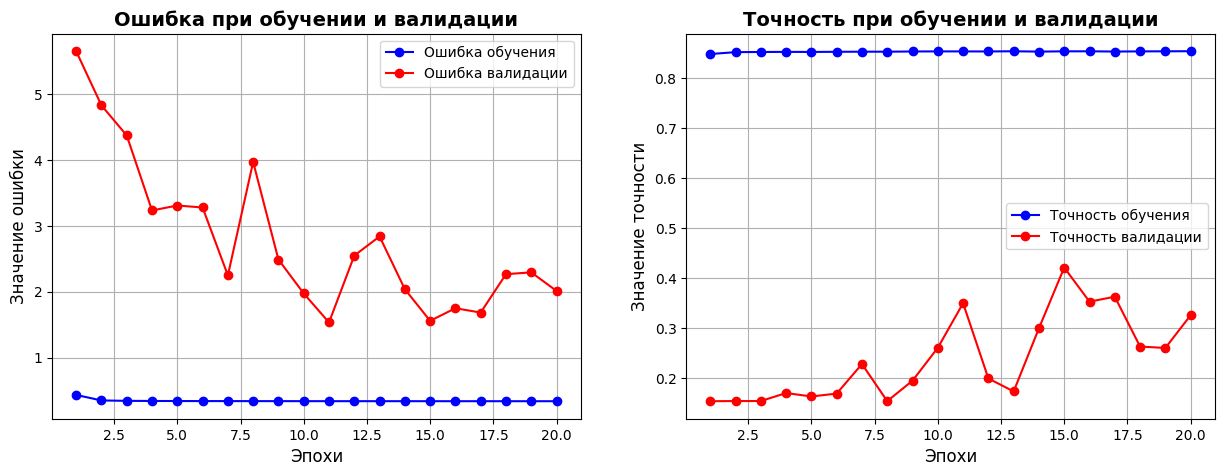

In [41]:
plot_training_curves(history1)

In [42]:
y_predicted_prob = model1.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

1435/1435 [==============================] - 2s 1ms/step


In [43]:
model1_preformance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.5609
Precision_score:	0.6071
Recall_score:		0.1380
AUC Score:		0.8163


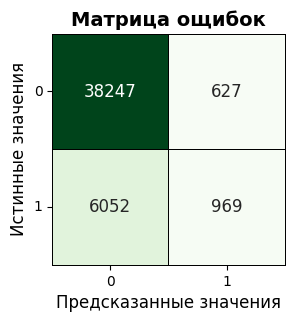

In [44]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

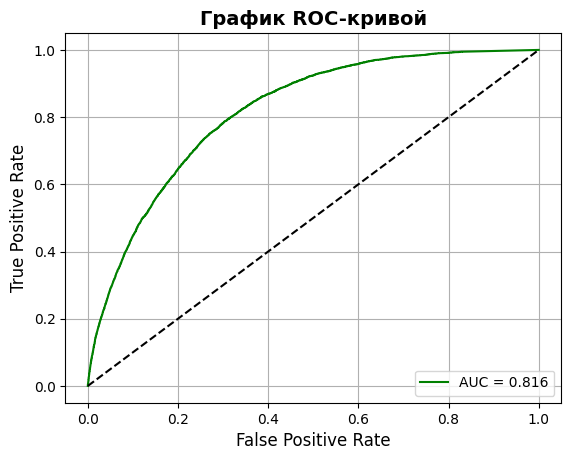

In [59]:
plot_roc_curve(y_test, y_predicted_prob)

## Модель 2

In [61]:
model2 = keras.Sequential([
    layers.Dense(32, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [62]:
# компиляция модели
model2.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 32)                704       
                                                                 
 dense_26 (Dense)            (None, 512)               16896     
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dense_28 (Dense)            (None, 64)                16448     
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 165441 (646.25 KB)
Trainable params: 165441 (646.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [63]:
history2 = model2.fit(X_train,
                      y_train,
                      epochs=50,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/50
4590/4590 [==============================] - 44s 8ms/step - loss: 0.3469 - accuracy: 0.8508 - val_loss: 0.7576 - val_accuracy: 0.4763
Epoch 2/50
4590/4590 [==============================] - 34s 7ms/step - loss: 0.3418 - accuracy: 0.8525 - val_loss: 1.0842 - val_accuracy: 0.2430
Epoch 3/50
4590/4590 [==============================] - 27s 6ms/step - loss: 0.3408 - accuracy: 0.8528 - val_loss: 1.3877 - val_accuracy: 0.3618
Epoch 4/50
4590/4590 [==============================] - 28s 6ms/step - loss: 0.3397 - accuracy: 0.8533 - val_loss: 1.0087 - val_accuracy: 0.4556
Epoch 5/50
4590/4590 [==============================] - 28s 6ms/step - loss: 0.3392 - accuracy: 0.8532 - val_loss: 0.6548 - val_accuracy: 0.5763
Epoch 6/50
4590/4590 [==============================] - 27s 6ms/step - loss: 0.3387 - accuracy: 0.8534 - val_loss: 0.7387 - val_accuracy: 0.6675
Epoch 7/50
4590/4590 [==============================] - 27s 6ms/step - loss: 0.3381 - accuracy: 0.8539 - val_loss: 0.6218 - val_ac

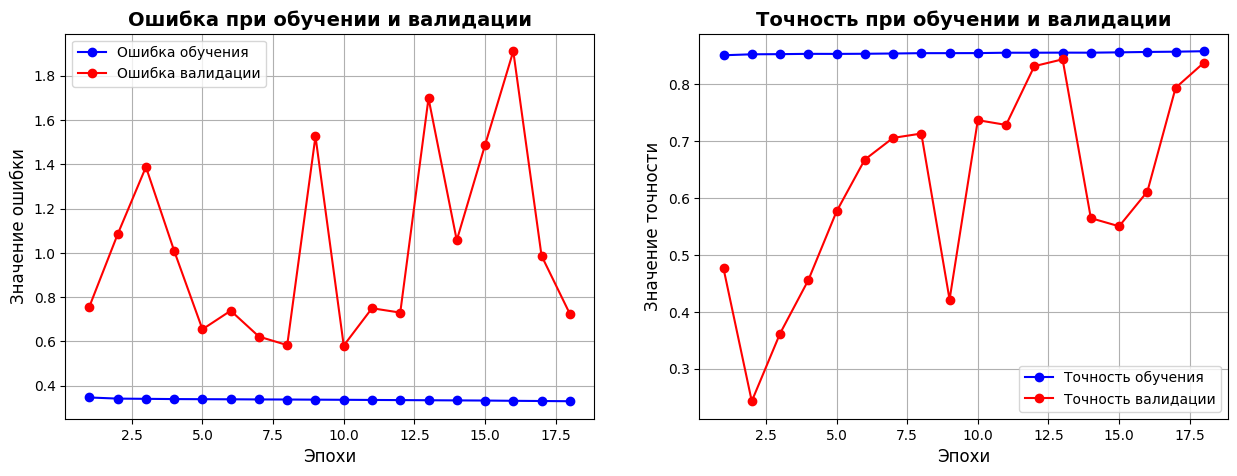

In [64]:
plot_training_curves(history2)

In [65]:
y_predicted_prob = model2.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

1435/1435 [==============================] - 3s 2ms/step


In [66]:
model2_preformance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.5702
Precision_score:	0.5619
Recall_score:		0.1635
AUC Score:		0.8126


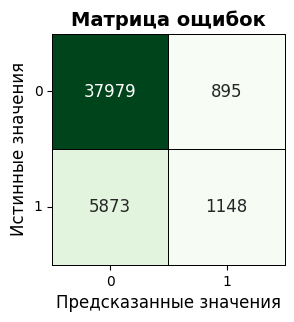

In [67]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

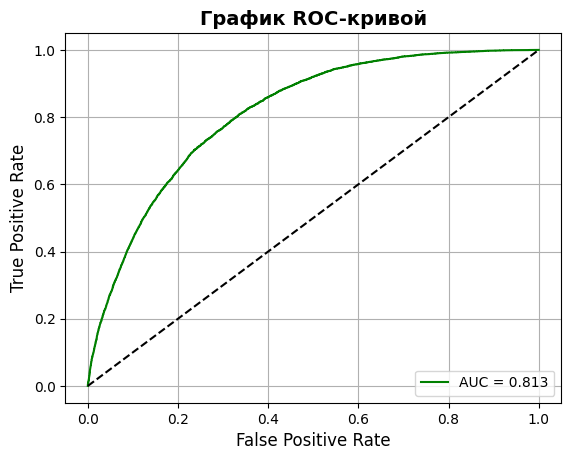

In [68]:
plot_roc_curve(y_test, y_predicted_prob)

# Новый признаки

In [69]:
corr = df.corr()
corr["Diabetes_binary"]

Diabetes_binary         1.000000
HighBP                  0.254318
HighChol                0.194944
CholCheck               0.072523
BMI                     0.205086
Smoker                  0.045504
Stroke                  0.099193
HeartDiseaseorAttack    0.168213
PhysActivity           -0.100404
Fruits                 -0.024805
Veggies                -0.041734
HvyAlcoholConsump      -0.065950
AnyHealthcare           0.025331
NoDocbcCost             0.020048
GenHlth                 0.276940
MentHlth                0.054153
PhysHlth                0.156211
DiffWalk                0.205302
Sex                     0.032724
Age                     0.177263
Education              -0.102686
Income                 -0.140659
Name: Diabetes_binary, dtype: float64

In [71]:
th=0.1

corr_th = corr["Diabetes_binary"][corr["Diabetes_binary"] > th]
corr_th

Diabetes_binary         1.000000
HighBP                  0.254318
HighChol                0.194944
BMI                     0.205086
HeartDiseaseorAttack    0.168213
GenHlth                 0.276940
PhysHlth                0.156211
DiffWalk                0.205302
Age                     0.177263
Name: Diabetes_binary, dtype: float64

In [72]:
new_df = df.drop(corr["Diabetes_binary"][corr["Diabetes_binary"] <= th].keys(), axis=1)
new_df.head()

,Diabetes_binary,HighBP,HighChol,BMI,HeartDiseaseorAttack,GenHlth,PhysHlth,DiffWalk,Age
0,0.0,1.0,1.0,40.0,0.0,5.0,15.0,1.0,9.0
1,0.0,0.0,0.0,25.0,0.0,3.0,0.0,0.0,7.0
2,0.0,1.0,1.0,28.0,0.0,5.0,30.0,1.0,9.0
3,0.0,1.0,0.0,27.0,0.0,2.0,0.0,0.0,11.0
4,0.0,1.0,1.0,24.0,0.0,2.0,0.0,0.0,11.0


# Деление на выборки

In [73]:
# делим выборку на тренировочную и тестовую
X = new_df.drop(['Diabetes_binary'],axis=1).values # удаляем целевую переменную из общего набора данных
y = new_df['Diabetes_binary'].values # создаем отделтнуб переменную для целевого признака
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и тестовый в соотношениии 80/20 (train/test)
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и валидационный в соотношениии 80/20 (train/test)

In [74]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер тренировочной выборки: (146863, 8)
Размер тестовой выборки: (45895, 8)
Размер валидационной выборки: (36716, 8)


In [75]:
# проводим стандартизацию данных, для лучшей работы нейронной сети
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Модель 1

In [76]:
model2_new = keras.Sequential([
    layers.Dense(32, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [77]:
# компиляция модели
model2_new.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model2_new.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 32)                288       
                                                                 
 dense_31 (Dense)            (None, 512)               16896     
                                                                 
 dense_32 (Dense)            (None, 256)               131328    
                                                                 
 dense_33 (Dense)            (None, 64)                16448     
                                                                 
 dense_34 (Dense)            (None, 1)                 65        
                                                                 
Total params: 165025 (644.63 KB)
Trainable params: 165025 (644.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [78]:
history2_new = model2_new.fit(X_train,
                      y_train,
                      epochs=50,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/50
4590/4590 [==============================] - 35s 7ms/step - loss: 0.3487 - accuracy: 0.8509 - val_loss: 0.6904 - val_accuracy: 0.6497
Epoch 2/50
4590/4590 [==============================] - 30s 7ms/step - loss: 0.3457 - accuracy: 0.8522 - val_loss: 0.7935 - val_accuracy: 0.4200
Epoch 3/50
4590/4590 [==============================] - 27s 6ms/step - loss: 0.3448 - accuracy: 0.8527 - val_loss: 0.6676 - val_accuracy: 0.6092
Epoch 4/50
4590/4590 [==============================] - 29s 6ms/step - loss: 0.3444 - accuracy: 0.8528 - val_loss: 0.9990 - val_accuracy: 0.4880
Epoch 5/50
4590/4590 [==============================] - 27s 6ms/step - loss: 0.3440 - accuracy: 0.8529 - val_loss: 0.6002 - val_accuracy: 0.7689
Epoch 6/50
4590/4590 [==============================] - 27s 6ms/step - loss: 0.3438 - accuracy: 0.8530 - val_loss: 0.5051 - val_accuracy: 0.8101
Epoch 7/50
4590/4590 [==============================] - 27s 6ms/step - loss: 0.3435 - accuracy: 0.8533 - val_loss: 0.5445 - val_ac

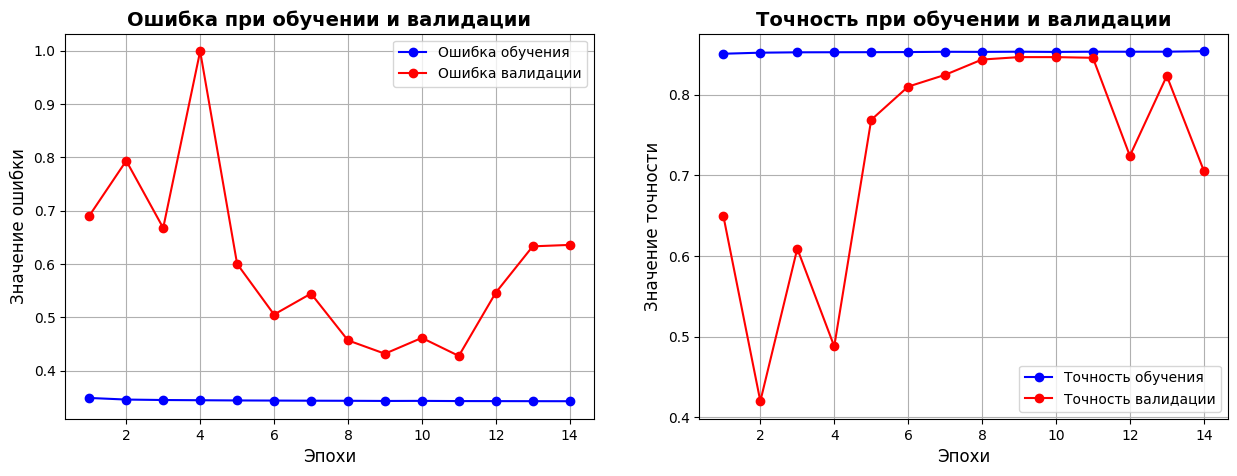

In [83]:
plot_training_curves(history2_new)

In [79]:
y_predicted_prob = model2_new.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

1435/1435 [==============================] - 3s 2ms/step


In [80]:
model2_new_preformance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.5742
Precision_score:	0.5643
Recall_score:		0.1725
AUC Score:		0.8122


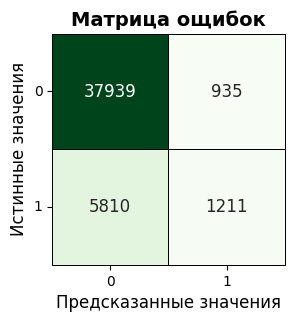

In [81]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

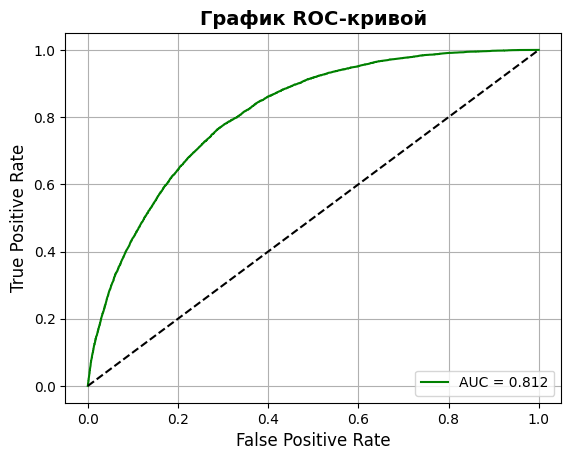

In [82]:
plot_roc_curve(y_test, y_predicted_prob)

## Модель 2

In [84]:
# создаем модель нейронной сети
model3 = keras.Sequential([
    layers.Dense(32, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [85]:
# компиляция модели
model3.compile(optimizer="adam",
              loss="binary_crossentropy"
              metrics=["accuracy"])
model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 32)                288       
                                                                 
 dense_36 (Dense)            (None, 512)               16896     
                                                                 
 dense_37 (Dense)            (None, 256)               131328    
                                                                 
 dense_38 (Dense)            (None, 256)               65792     
                                                                 
 dense_39 (Dense)            (None, 64)                16448     
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 dense_41 (Dense)            (None, 1)                

### Обучение

In [86]:
# обучение модели
history3 = model3.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/50
4590/4590 [==============================] - 46s 10ms/step - loss: 0.3500 - accuracy: 0.8504 - val_loss: 0.5973 - val_accuracy: 0.6819
Epoch 2/50
4590/4590 [==============================] - 34s 7ms/step - loss: 0.3464 - accuracy: 0.8518 - val_loss: 0.9240 - val_accuracy: 0.2625
Epoch 3/50
4590/4590 [==============================] - 35s 8ms/step - loss: 0.3453 - accuracy: 0.8519 - val_loss: 0.6275 - val_accuracy: 0.6474
Epoch 4/50
4590/4590 [==============================] - 35s 8ms/step - loss: 0.3451 - accuracy: 0.8523 - val_loss: 0.6461 - val_accuracy: 0.7217
Epoch 5/50
4590/4590 [==============================] - 34s 7ms/step - loss: 0.3444 - accuracy: 0.8529 - val_loss: 0.5293 - val_accuracy: 0.8168
Epoch 6/50
4590/4590 [==============================] - 34s 7ms/step - loss: 0.3441 - accuracy: 0.8528 - val_loss: 0.4549 - val_accuracy: 0.8452
Epoch 7/50
4590/4590 [==============================] - 36s 8ms/step - loss: 0.3440 - accuracy: 0.8528 - val_loss: 0.6341 - val_a

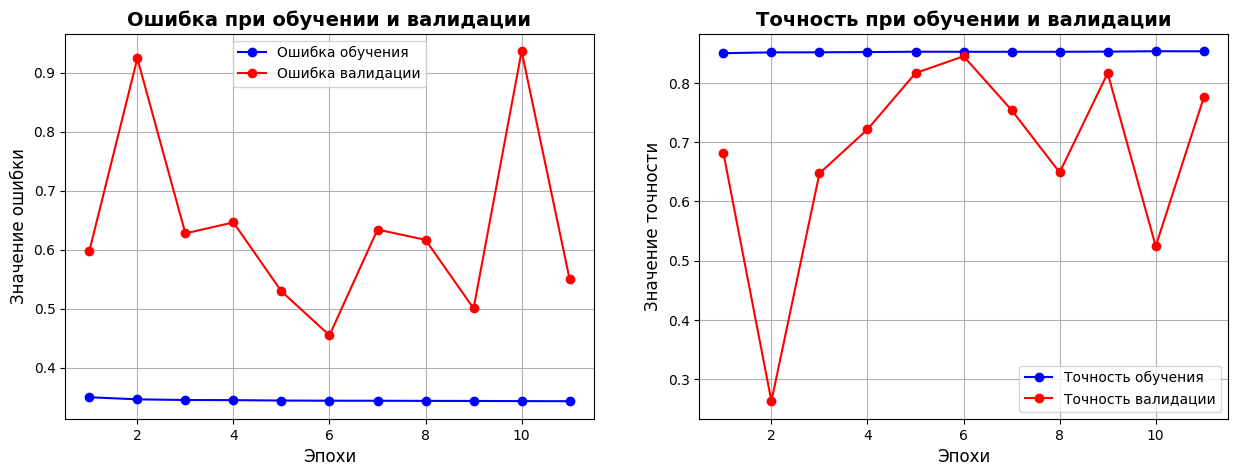

In [87]:
plot_training_curves(history3)

In [88]:
y_predicted_prob = model3.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

1435/1435 [==============================] - 4s 3ms/step


In [89]:
model3_new_preformance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.5589
Precision_score:	0.5917
Recall_score:		0.1346
AUC Score:		0.8126


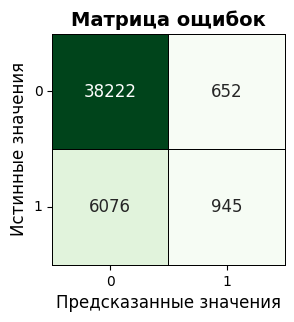

In [90]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

# Oversampling

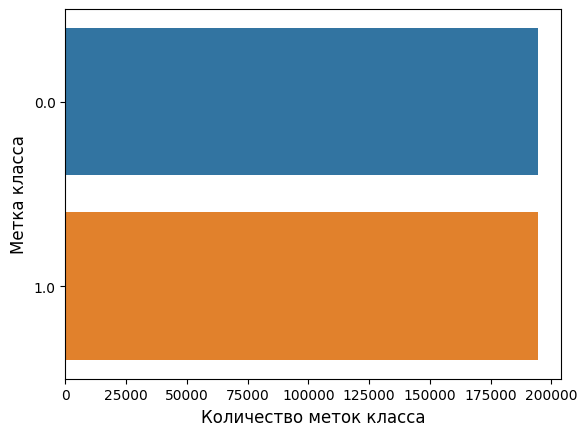

In [107]:
class_0 = df[df['Diabetes_binary'] == 0]
class_1 = df[df['Diabetes_binary'] == 1]

class_1_over = class_1.sample(len(class_0), replace=True)

df_over = pd.concat([class_1_over, class_0], axis=0)

# визуализация количества меток класса
sns.countplot(y=df_over['Diabetes_binary'] ,data=df_over)
plt.xlabel("Количество меток класса", fontsize=12)
plt.ylabel("Метка класса", fontsize=12)
plt.show()

# Деление на выборки

In [108]:
# делим выборку на тренировочную и тестовую
X = df_over.drop(['Diabetes_binary'],axis=1).values # удаляем целевую переменную из общего набора данных
y = df_over['Diabetes_binary'].values # создаем отделтнуб переменную для целевого признака
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и тестовый в соотношениии 80/20 (train/test)
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и валидационный в соотношениии 80/20 (train/test)

In [110]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер тренировочной выборки: (248802, 21)
Размер тестовой выборки: (77751, 21)
Размер валидационной выборки: (62201, 21)


In [111]:
# проводим стандартизацию данных, для лучшей работы нейронной сети
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Модель 1

In [112]:
model1_over = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [113]:
# компиляция модели
model1_over.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model1_over.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 12)                264       
                                                                 
 dense_48 (Dense)            (None, 8)                 104       
                                                                 
 dense_49 (Dense)            (None, 4)                 36        
                                                                 
 dense_50 (Dense)            (None, 1)                 5         
                                                                 
Total params: 409 (1.60 KB)
Trainable params: 409 (1.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [114]:
history1_over = model1_over.fit(X_train,
                      y_train,
                      epochs=50,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/50
7776/7776 [==============================] - 31s 4ms/step - loss: 0.5326 - accuracy: 0.7302 - val_loss: 2.8694 - val_accuracy: 0.4997
Epoch 2/50
7776/7776 [==============================] - 18s 2ms/step - loss: 0.5218 - accuracy: 0.7381 - val_loss: 2.7067 - val_accuracy: 0.4997
Epoch 3/50
7776/7776 [==============================] - 17s 2ms/step - loss: 0.5208 - accuracy: 0.7388 - val_loss: 2.3325 - val_accuracy: 0.4998
Epoch 4/50
7776/7776 [==============================] - 18s 2ms/step - loss: 0.5201 - accuracy: 0.7388 - val_loss: 2.2056 - val_accuracy: 0.5004
Epoch 5/50
7776/7776 [==============================] - 18s 2ms/step - loss: 0.5197 - accuracy: 0.7392 - val_loss: 1.5449 - val_accuracy: 0.5181
Epoch 6/50
7776/7776 [==============================] - 21s 3ms/step - loss: 0.5195 - accuracy: 0.7390 - val_loss: 1.8723 - val_accuracy: 0.5044
Epoch 7/50
7776/7776 [==============================] - 18s 2ms/step - loss: 0.5193 - accuracy: 0.7394 - val_loss: 2.3062 - val_ac

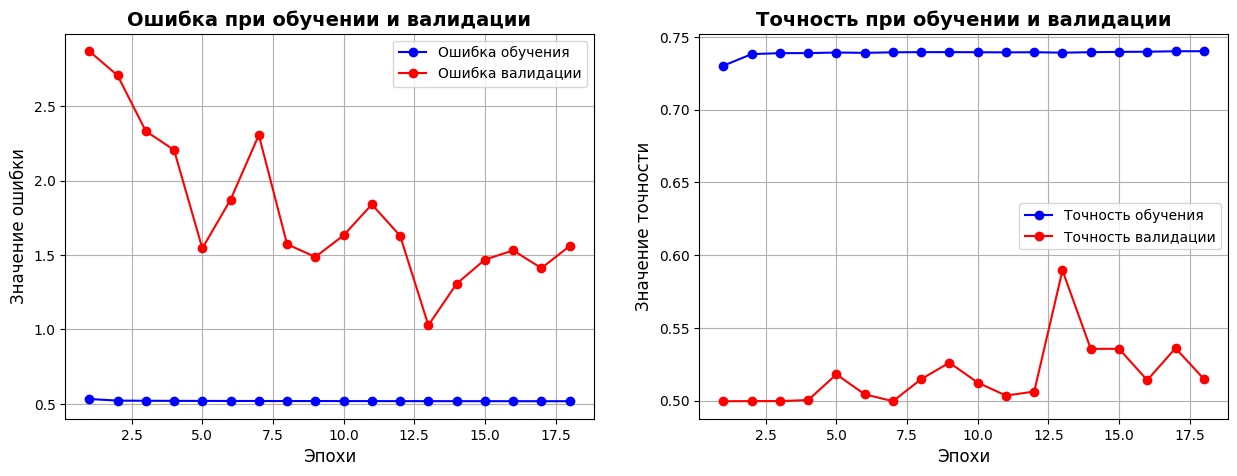

In [115]:
plot_training_curves(history1_over)

In [116]:
y_predicted_prob = model1_over.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

2430/2430 [==============================] - 3s 1ms/step


In [117]:
model1_over_preformance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.7377
Precision_score:	0.7201
Recall_score:		0.7835
AUC Score:		0.8146


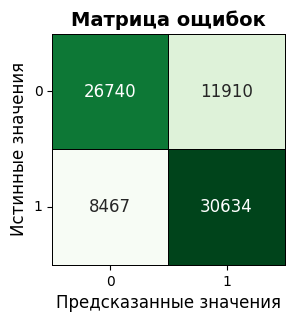

In [118]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

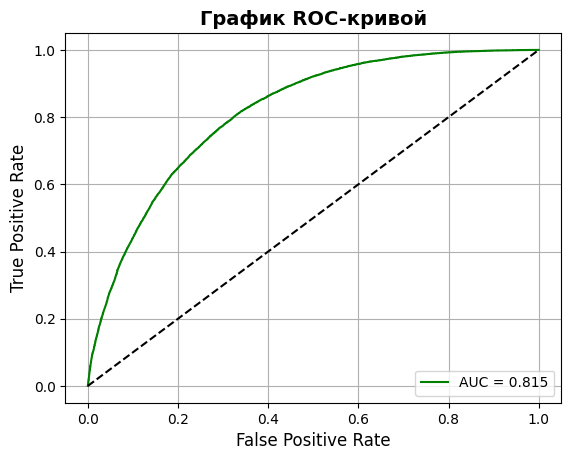

In [119]:
plot_roc_curve(y_test, y_predicted_prob)

## Модель 2

In [120]:
# создаем модель нейронной сети
model3_over = keras.Sequential([
    layers.Dense(32, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [122]:
# компиляция модели
model3_over.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model3_over.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 32)                704       
                                                                 
 dense_52 (Dense)            (None, 512)               16896     
                                                                 
 dense_53 (Dense)            (None, 256)               131328    
                                                                 
 dense_54 (Dense)            (None, 256)               65792     
                                                                 
 dense_55 (Dense)            (None, 64)                16448     
                                                                 
 dense_56 (Dense)            (None, 32)                2080      
                                                                 
 dense_57 (Dense)            (None, 1)               

### Обучение

In [123]:
# обучение модели
history3_over = model3_over.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/50
7776/7776 [==============================] - 70s 9ms/step - loss: 0.5283 - accuracy: 0.7343 - val_loss: 1.3724 - val_accuracy: 0.5934
Epoch 2/50
7776/7776 [==============================] - 58s 8ms/step - loss: 0.5203 - accuracy: 0.7397 - val_loss: 1.2919 - val_accuracy: 0.5710
Epoch 3/50
7776/7776 [==============================] - 60s 8ms/step - loss: 0.5171 - accuracy: 0.7421 - val_loss: 0.8048 - val_accuracy: 0.5958
Epoch 4/50
7776/7776 [==============================] - 60s 8ms/step - loss: 0.5131 - accuracy: 0.7450 - val_loss: 1.4526 - val_accuracy: 0.5946
Epoch 5/50
7776/7776 [==============================] - 59s 8ms/step - loss: 0.5078 - accuracy: 0.7492 - val_loss: 0.7883 - val_accuracy: 0.5979
Epoch 6/50
7776/7776 [==============================] - 60s 8ms/step - loss: 0.5004 - accuracy: 0.7553 - val_loss: 0.8002 - val_accuracy: 0.5923
Epoch 7/50
7776/7776 [==============================] - 60s 8ms/step - loss: 0.4917 - accuracy: 0.7630 - val_loss: 1.7572 - val_ac

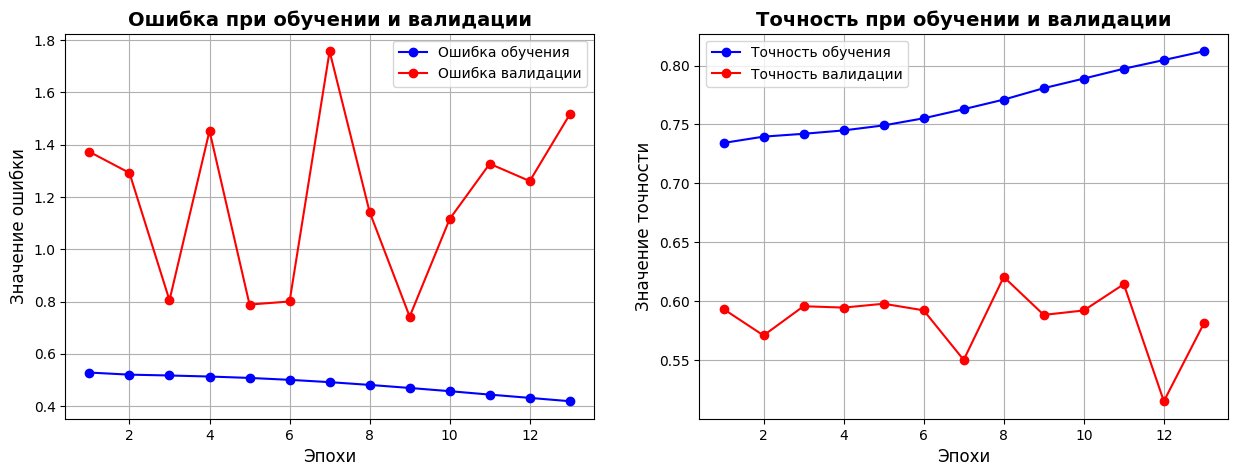

In [124]:
plot_training_curves(history3_over)

In [125]:
y_predicted_prob = model3_over.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

2430/2430 [==============================] - 6s 2ms/step


In [126]:
model3_over_preformance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.7859
Precision_score:	0.7518
Recall_score:		0.8585
AUC Score:		0.8539


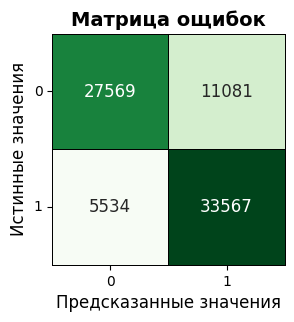

In [127]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

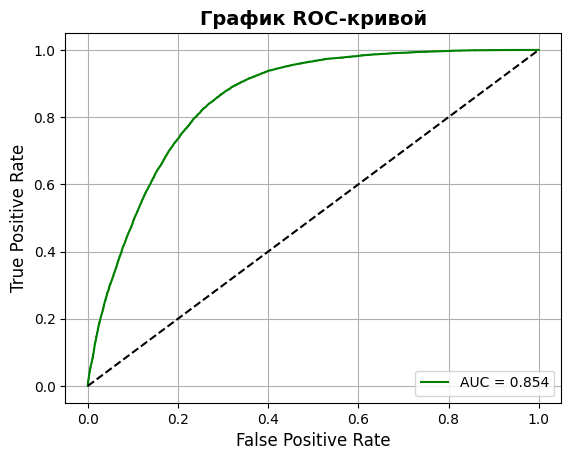

In [128]:
plot_roc_curve(y_test, y_predicted_prob)

## Модель 3

In [129]:
# создаем модель нейронной сети
model4_over = keras.Sequential([
    layers.Dense(64, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(1024, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [130]:
# компиляция модели
model4_over.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model4_over.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 64)                1408      
                                                                 
 dense_59 (Dense)            (None, 512)               33280     
                                                                 
 dense_60 (Dense)            (None, 1024)              525312    
                                                                 
 dense_61 (Dense)            (None, 256)               262400    
                                                                 
 dense_62 (Dense)            (None, 64)                16448     
                                                                 
 dense_63 (Dense)            (None, 32)                2080      
                                                                 
 dense_64 (Dense)            (None, 1)               

### Обучение

In [131]:
# обучение модели
history4_over = model4_over.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/50
7776/7776 [==============================] - 139s 18ms/step - loss: 0.5278 - accuracy: 0.7361 - val_loss: 3.5957 - val_accuracy: 0.4997
Epoch 2/50
7776/7776 [==============================] - 130s 17ms/step - loss: 0.5193 - accuracy: 0.7401 - val_loss: 1.4747 - val_accuracy: 0.5004
Epoch 3/50
7776/7776 [==============================] - 131s 17ms/step - loss: 0.5147 - accuracy: 0.7438 - val_loss: 1.3076 - val_accuracy: 0.5232
Epoch 4/50
7776/7776 [==============================] - 131s 17ms/step - loss: 0.5085 - accuracy: 0.7481 - val_loss: 0.9605 - val_accuracy: 0.5804
Epoch 5/50
7776/7776 [==============================] - 130s 17ms/step - loss: 0.5008 - accuracy: 0.7545 - val_loss: 6.5936 - val_accuracy: 0.5577
Epoch 6/50
7776/7776 [==============================] - 127s 16ms/step - loss: 0.4900 - accuracy: 0.7633 - val_loss: 1.0844 - val_accuracy: 0.6217
Epoch 7/50
7776/7776 [==============================] - 130s 17ms/step - loss: 0.4770 - accuracy: 0.7724 - val_loss: 4

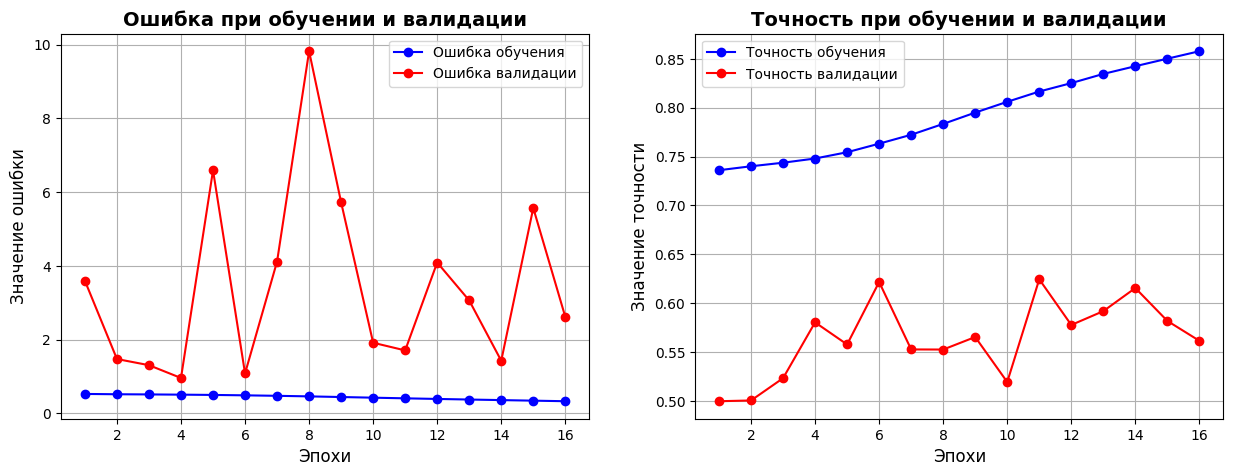

In [132]:
plot_training_curves(history4_over)

In [133]:
y_predicted_prob = model4_over.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

2430/2430 [==============================] - 13s 5ms/step


In [134]:
model4_over_preformance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.8211
Precision_score:	0.7928
Recall_score:		0.8730
AUC Score:		0.8863


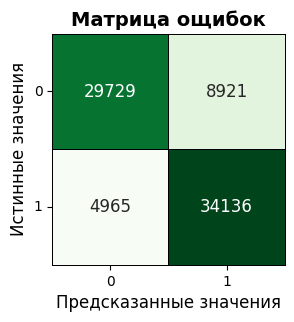

In [135]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

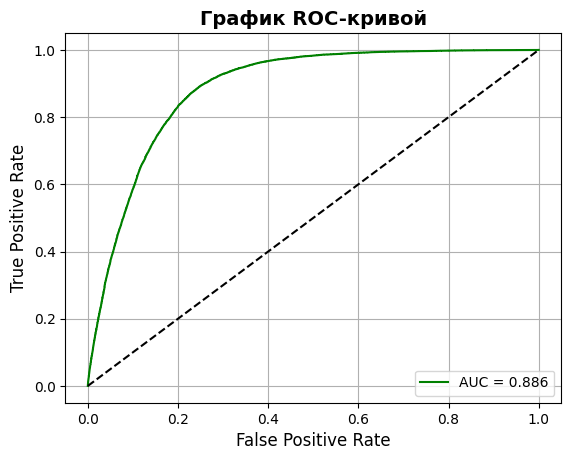

In [136]:
plot_roc_curve(y_test, y_predicted_prob)

## Модель 4

In [138]:
# создаем модель нейронной сети
model5_over = keras.Sequential([
    layers.Dense(64, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(1024, activation="relu"),
    layers.Dense(1024, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [139]:
# компиляция модели
model5_over.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model5_over.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 64)                1408      
                                                                 
 dense_66 (Dense)            (None, 512)               33280     
                                                                 
 dense_67 (Dense)            (None, 1024)              525312    
                                                                 
 dense_68 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_69 (Dense)            (None, 512)               524800    
                                                                 
 dense_70 (Dense)            (None, 256)               131328    
                                                                 
 dense_71 (Dense)            (None, 64)              

### Обучение

In [140]:
# обучение модели
history5_over = model5_over.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/50
7776/7776 [==============================] - 334s 43ms/step - loss: 0.5287 - accuracy: 0.7356 - val_loss: 1.6763 - val_accuracy: 0.4997
Epoch 2/50
7776/7776 [==============================] - 333s 43ms/step - loss: 0.5203 - accuracy: 0.7407 - val_loss: 1.5376 - val_accuracy: 0.5507
Epoch 3/50
7776/7776 [==============================] - 321s 41ms/step - loss: 0.5162 - accuracy: 0.7423 - val_loss: 1.4520 - val_accuracy: 0.5390
Epoch 4/50
7776/7776 [==============================] - 329s 42ms/step - loss: 0.5122 - accuracy: 0.7446 - val_loss: 1.7908 - val_accuracy: 0.5688
Epoch 5/50
7776/7776 [==============================] - 318s 41ms/step - loss: 0.5055 - accuracy: 0.7504 - val_loss: 1.2496 - val_accuracy: 0.5566
Epoch 6/50
7776/7776 [==============================] - 318s 41ms/step - loss: 0.4970 - accuracy: 0.7573 - val_loss: 1.3556 - val_accuracy: 0.5595
Epoch 7/50
7776/7776 [==============================] - 328s 42ms/step - loss: 0.4855 - accuracy: 0.7666 - val_loss: 1

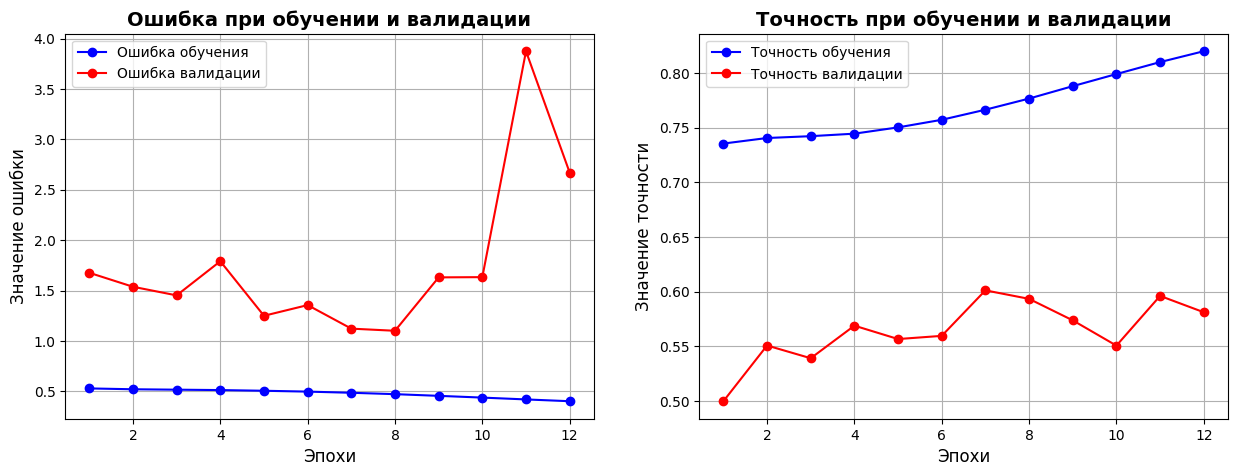

In [141]:
plot_training_curves(history5_over)

In [142]:
y_predicted_prob = model5_over.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

2430/2430 [==============================] - 22s 9ms/step


In [143]:
model5_over_preformance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.7976
Precision_score:	0.7629
Recall_score:		0.8680
AUC Score:		0.8666


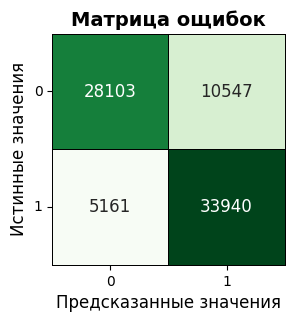

In [144]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

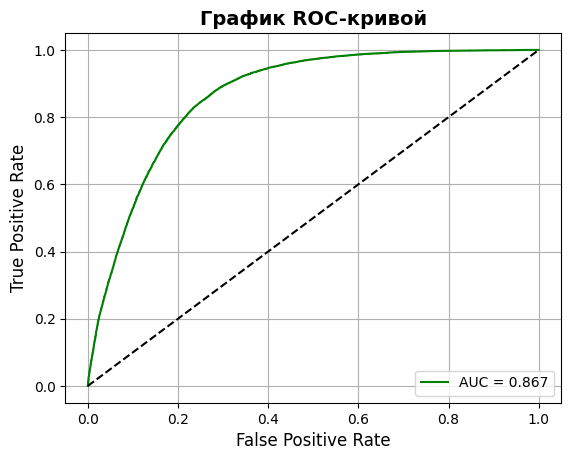

In [145]:
plot_roc_curve(y_test, y_predicted_prob)

In [ ]:
model3